In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

harshvardhini01_graphh_path = kagglehub.dataset_download('harshvardhini01/graphh')
harshvardhini01_dataaa_path = kagglehub.dataset_download('harshvardhini01/dataaa')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#### This code systematically generates and visualizes all unique, connected directed subgraphs that can be formed using 3 nodes, ensuring no duplicates based on graph isomorphism. The approach is divided into the following steps:

### 1. Identification and Classification of Unique Subgraphs

#### - The node set is fixed as [0, 1, 2], ensuring all subgraphs are based on the same set of nodes.

#### - This yields a total of 3×2=6 directed edges between the nodes.

#### - The code then uses combinations of 2 or more edges (up to 6) to generate potential edge sets. This ensures a wide search space while avoiding trivial disconnected subgraphs.

#### - After creating a graph from each edge set, only weakly connected graphs are kept. This filters out disconnected structures, as required for the task.

#### - Isomorphism checking is then performed to ensure uniqueness. This guarantees that only structurally distinct graphs (up to node relabeling) are retained.

### 2. Efficient Strategy Implementation

#### The code efficiently generates unique 3-node directed connected subgraphs by considering only edge combinations of size 2 to 6, thus avoiding trivial disconnected cases. It filters out weakly disconnected graphs early, reducing unnecessary computation. To ensure uniqueness, it uses NetworkX’s DiGraphMatcher for isomorphism checks, eliminating the need for manual comparisons and retaining only structurally distinct graphs. The final list contains only connected, non-isomorphic subgraphs, which are then visualized using matplotlib.

In [ ]:
import networkx as nx
from itertools import permutations, combinations

unique_graphs = []

nodes = [0, 1, 2]
all_possible_edges = [(i, j) for i in nodes for j in nodes if i != j]

for r in range(2, len(all_possible_edges)+1):
    for edges in combinations(all_possible_edges, r):
        G = nx.DiGraph()
        G.add_nodes_from(nodes)
        G.add_edges_from(edges)

        if not nx.is_weakly_connected(G):
            continue

        GM = nx.algorithms.isomorphism.DiGraphMatcher
        is_duplicate = False
        for UG in unique_graphs:
            if GM(G, UG).is_isomorphic():
                is_duplicate = True
                break

        if not is_duplicate:
            unique_graphs.append(G)


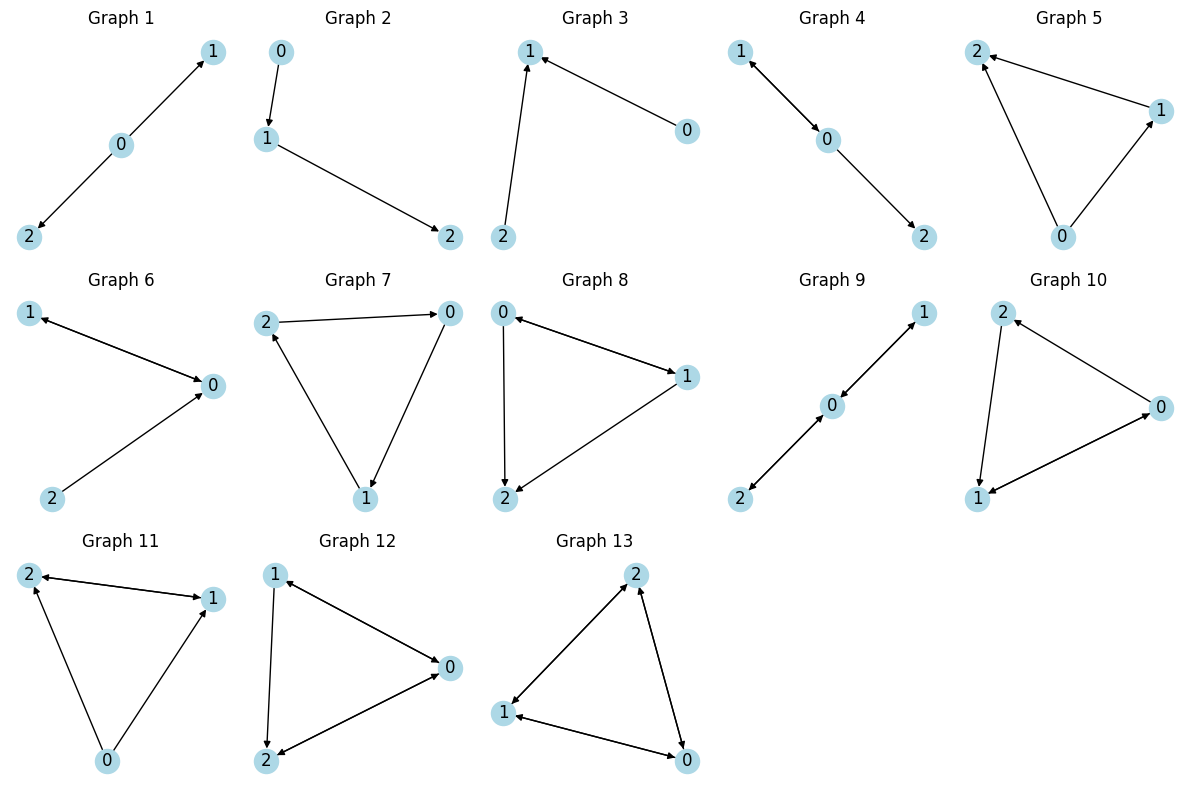

In [ ]:
import matplotlib.pyplot as plt

def draw_graphs(graphs):
    plt.figure(figsize=(12, 8))
    for i, G in enumerate(graphs):
        plt.subplot(3, 5, i+1)
        nx.draw(G, with_labels=True, node_color='lightblue', arrows=True)
        plt.title(f"Graph {i+1}")
    plt.tight_layout()
    plt.show()

draw_graphs(unique_graphs)


### This code reads a file containing edge pairs, extracts all unique nodes and edges, and returns them as a sorted node list and an edge list.

In [ ]:
def read(path):
    edges = []
    nodes = set()
    with open(path, 'r') as f:
        for line in f:
            if line.strip():
                u, v = map(int, line.strip().split())
                edges.append((u, v))
                nodes.add(u)
                nodes.add(v)
    return sorted(list(nodes)), edges

### This below function extracts the subgraph with 300 nodes from a giant graph for faster execution

In [ ]:
import random
def extract_subgraph(nodes, edges):
    num_nodes=300
    subset_nodes = set(random.sample(nodes, num_nodes))
    subset_edges = [(u, v) for u, v in edges if u in subset_nodes and v in subset_nodes]
    return sorted(list(subset_nodes)), subset_edges

### Reading the graph txt file and storing them

In [ ]:
real_node_list, real_edges = read("/kaggle/input/graphh/email-Eu-core.txt")

### Extracting subgraph from real graph

In [ ]:
subset_nodes, subset_edges = extract_subgraph(real_node_list, real_edges)

### Saving the subset graph

In [ ]:
with open("subset_real_graph.txt", 'w') as f:
        for u, v in subset_edges:
            f.write(f"{u} {v}\n")

### Randomisation method for Comparision

#### To assess the significance of subgraph occurrences in the real graph, the code uses a randomization technique based on edge swaps. Specifically, it generates 100 randomized versions of the original graph (real_graph) using the randomize_graph_edge_swaps function. This method:

#### Preserves the in-degree and out-degree distribution of the original graph.

#### Swaps pairs of directed edges if the swap doesn't create self-loops or duplicate edges.

#### Performs up to a set number of swaps (num_swaps=5000 by default) or until a max number of attempts is reached.

#### This generates randomized graphs that maintain structural properties of the original graph but with a randomized edge arrangement. Comparing subgraph counts in the real graph versus these randomized graphs helps evaluate whether the observed subgraph frequency is statistically significant or due to chance.

In [ ]:
import networkx as nx
import itertools
import numpy as np
import pickle
import os
import random

SUBGRAPH_INDEX = 0
SAVE_PATH = f"subgraph_{SUBGRAPH_INDEX+1}_counts.pkl"

def load_graph_from_txt(file_path):
    G = nx.DiGraph()
    with open(file_path, 'r') as f:
        for line in f:
            u, v = map(int, line.strip().split())
            G.add_edge(u, v)
    return G

def is_isomorphic(G1, G2):
    if G1.number_of_nodes() != G2.number_of_nodes() or G1.number_of_edges() != G2.number_of_edges():
        return False

    nodes1 = list(G1.nodes())
    nodes2 = list(G2.nodes())

    for perm in itertools.permutations(nodes2):
        mapping = dict(zip(nodes1, perm))
        if all((mapping[u], mapping[v]) in G2.edges() for u, v in G1.edges()):
            return True
    return False

def count_subgraph_occurrences(big_graph, small_graph):
    count = 0
    num_nodes = small_graph.number_of_nodes()

    for nodes in itertools.combinations(big_graph.nodes(), num_nodes):
        subG = big_graph.subgraph(nodes).copy()
        if nx.is_weakly_connected(subG) and is_isomorphic(small_graph, subG):
            count += 1
    return count

def randomize_graph_edge_swaps(G, num_swaps=10000, max_attempts_factor=10):
    G_rand = G.copy()
    edges = list(G_rand.edges())
    swaps = 0
    attempts = 0
    max_attempts = max_attempts_factor * num_swaps

    while swaps < num_swaps and attempts < max_attempts:
        (u1, v1), (u2, v2) = random.sample(edges, 2)

        # Avoid creating self-loops or duplicate edges
        if len(set([u1, v1, u2, v2])) < 4:
            attempts += 1
            continue
        if G_rand.has_edge(u1, v2) or G_rand.has_edge(u2, v1):
            attempts += 1
            continue

        # Perform the edge swap
        G_rand.remove_edge(u1, v1)
        G_rand.remove_edge(u2, v2)
        G_rand.add_edge(u1, v2)
        G_rand.add_edge(u2, v1)

        # Update edge list
        edges.remove((u1, v1))
        edges.remove((u2, v2))
        edges.append((u1, v2))
        edges.append((u2, v1))

        swaps += 1

    return G_rand

real_graph = load_graph_from_txt("/kaggle/working/subset_real_graph.txt")

subgraph = unique_graphs[SUBGRAPH_INDEX]

print(f"Counting occurrences for Subgraph {SUBGRAPH_INDEX+1}")

Nreal = count_subgraph_occurrences(real_graph, subgraph)
print(f"Subgraph {SUBGRAPH_INDEX+1}: Real Graph Count = {Nreal}")

random_graphs = []
for i in range(100):
    randomized = randomize_graph_edge_swaps(real_graph, num_swaps=5000)
    random_graphs.append(randomized)

Nrand_list = []
for i, rg in enumerate(random_graphs):
    count = count_subgraph_occurrences(rg, subgraph)
    Nrand_list.append(count)
    print(f"Random Graph {i+1} done  Count = {count}")

with open(SAVE_PATH, "wb") as f:
    pickle.dump({"Nreal": Nreal, "Nrand_list": Nrand_list}, f)

print(f"\n Completed Subgraph {SUBGRAPH_INDEX+1}  Results saved to {SAVE_PATH}")


Counting occurrences for Subgraph 1
Subgraph 1: Real Graph Count = 2
Random Graph 1 done → Count = 8
Random Graph 2 done → Count = 9
Random Graph 3 done → Count = 6
Random Graph 4 done → Count = 10
Random Graph 5 done → Count = 3
Random Graph 6 done → Count = 7
Random Graph 7 done → Count = 5
Random Graph 8 done → Count = 3
Random Graph 9 done → Count = 5
Random Graph 10 done → Count = 14
Random Graph 11 done → Count = 2
Random Graph 12 done → Count = 10
Random Graph 13 done → Count = 13
Random Graph 14 done → Count = 4
Random Graph 15 done → Count = 10
Random Graph 16 done → Count = 10
Random Graph 17 done → Count = 22
Random Graph 18 done → Count = 8
Random Graph 19 done → Count = 4
Random Graph 20 done → Count = 3
Random Graph 21 done → Count = 8
Random Graph 22 done → Count = 4
Random Graph 23 done → Count = 17
Random Graph 24 done → Count = 11
Random Graph 25 done → Count = 10
Random Graph 26 done → Count = 10
Random Graph 27 done → Count = 10
Random Graph 28 done → Count = 2
Rand

### This above code is for one subgraph, like this i runned it for 5 separate graphs in different notebooks so that i could get the resuls faster. The code is same for all the subgraphs just the subgraph is different. I stored Nreal and Nrand list in .pkl file for each subgraph and then as you can see below loaded the .pkl files for all 5 graphs and then computed the results.

### Here are the screenshots that i have runned

![image.png](attachment:4280cb48-e1e7-4217-aa12-2d6aa8ae79f8.png)
![image.png](attachment:308fd3ea-cd5a-42c2-9bd5-2ef68f90e36c.png)
![image.png](attachment:b2cec98d-c5b0-4086-9ba8-a167f8a3d8ba.png)
![image.png](attachment:617f2e16-e91d-4f25-9bd1-7f31b066aca2.png)

![image.png](attachment:1f20370b-5112-4d5f-9d0f-8367c1272c86.png)
#### correctly calculated Z score in below code like as seen above.
#### where Nreal is the number of times the subgraph appears in the real graph.
#### μ is the mean count in the randomized graphs.
#### σ is the standard deviation of the counts in randomized graphs.

#### Based on the Z-score threshold: Motifs are subgraphs with Z > +2, Anti-Motifs are subgraphs with Z < -2, Others are Neutral

In [ ]:
import pickle
import numpy as np

NUM_SUBGRAPHS = 5

for subgraph_index in range(NUM_SUBGRAPHS):
    file_path = f"/kaggle/input/dataaa/Dataaa/subgraph_{subgraph_index + 1}_counts.pkl"

    with open(file_path, "rb") as f:
        data = pickle.load(f)

    Nreal = data["Nreal"]
    Nrand_list = data["Nrand_list"]

    mean = np.mean(Nrand_list)
    std = np.std(Nrand_list)

    z = (Nreal - mean) / std if std > 0 else 0
    print(f"\n Subgraph {subgraph_index + 1}")
    print(f"Real count: {Nreal}")
    print(f"Random mean: {mean:.2f}, std: {std:.2f}")
    print(f"Z-score: {z:.2f}")

    if z > 2:
        print(" Motif")
    elif z < -2:
        print(" Anti-Motif")
    else:
        print(" Neutral")



 Subgraph 1
Real count: 2
Random mean: 8.81, std: 5.64
Z-score: -1.21
→ Neutral

 Subgraph 2
Real count: 15
Random mean: 21.14, std: 10.43
Z-score: -0.59
→ Neutral

 Subgraph 3
Real count: 0
Random mean: 7.14, std: 3.75
Z-score: -1.91
→ Neutral

 Subgraph 4
Real count: 14
Random mean: 2.77, std: 4.11
Z-score: 2.73
→ Motif

 Subgraph 5
Real count: 1
Random mean: 2.66, std: 1.95
Z-score: -0.85
→ Neutral



#### From the above results we can see that Subgraph 4 is a Motif and as there are no Anti-Motifs detected as no Z-score < -2

### Structural Interpretation and Insights
#### The presence of a chain motif (Subgraph 4) suggests a strong underlying hierarchical or procedural structure in how people communicate via email in this dataset. This might align with workflows in corporate or institutional settings where communication often follows established chains of command.
Also anti motifs are absent but still 3 subgraph are very close to that almost -2 which shows us certian patterns are suppressed in real data compared to random networks probably due to some communication rules in the network.
overall the presence of cahin motifs and absence of antimotifs tell us that the netwotrk is highly ordered , it can be a hierarchical netwrok system with specific patterns being favoured.